# Проект e-commerce: вариант 1  

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?  

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может 
быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.  

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким 
retention на 3й месяц. Описание подхода можно найти тут. 

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй 
RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: 
R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, 
M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик 
recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, 
frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary 
от 1780 до 3560 рублей в неделю.  

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать 
свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

Файлы:

 olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

olist_orders_dataset.csv —  таблица заказов
order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан  
approved —  подтверждён  
invoiced —  выставлен счёт  
processing —  в процессе сборки заказа  
shipped —  отгружен со склада  
delivered —  доставлен пользователю  
unavailable —  недоступен  
canceled —  отменён

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import stats
sns.set(rc = {'figure.figsize':(15,8)})

Загрузим таблицу olist_customers_dataset

In [2]:
customers=pd.read_csv(f'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/t9Li4JOfgxuUrg', encoding = 'windows-1254', sep = ',')
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Загрузим таблицу olist_orders_dataset

In [3]:
orders=pd.read_csv(f'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/t9Li4JOfgxuUrg', encoding = 'windows-1254', sep = ',',parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


Проверим типы данных в таблице orders

In [4]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

Загрузим таблицу olist_order_items_dataset

In [5]:
order_items=pd.read_csv(f'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw', encoding = 'windows-1254', sep = ',', parse_dates=['shipping_limit_date'])
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


### 1. Сколько у нас пользователей, которые совершили покупку только один раз? 

Какая покупка считается совершенной? Т.е. это та покупка, за которую заплатили/находится в процессе доставки/доставлена. Рассмотрим каждый статус отдельно:  
created — создан - пользователь положил в корзину, заказ создан и принят системой, но если он его ещё не оплатил, то данное действие заказом не является, т.к. может передумать и отменить;  
approved — подтверждён - т.е. заказ принят, проверен менеджером магазина  
invoiced — выставлен счёт - после подтверждениия менеджер выставляет счет. На данном и предыдущем этапах покупка не считается совершенной, покупатель может и отменить;  
processing — в процессе сборки заказа. С этого момента покупка считается совершенной, ее оплатили и отправили на сборку;  
shipped — отгружен со склада. На данном этапе она тоже уже оплаченная и совершённая;  
delivered — доставлен пользователю - здесь покупка прошла свой полный цикл,доведена до своего полного завершенного состояния;  
unavailable — недоступен - заказ по какой-то причине недоступен - покупка не совершена;  
canceled — отменён - заказ на одном из этапов по какой-то причине отменен, даже если деньги заплачены, их вернули и заказ обнулен. Нет заказа - не было и покупки - покупка не совершена.  
Следовательно, за совершенные покупки примем все заказы, которые оплатили, при этом не отменены на каком-либо из этапов, т.е. это заказы со статусами: processing, shipped, delivered.

Соединяем таблицы customers и orders

In [6]:
customers_orders=customers.merge(orders, on='customer_id')
customers_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


Отбираем количество уникальных покупателей, которые совершили покупку 1 раз

In [7]:
customers_orders.query("order_status in ('processing', 'shipped', 'delivered')")\
    .groupby("customer_unique_id", as_index=False) \
    .agg({'customer_city':'count'}).query("customer_city == 1").customer_city.sum()

91814

### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

In [8]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [9]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

Создаем столбец с месяцем создания заказа

In [10]:
orders['month'] = orders['order_purchase_timestamp'].dt.strftime('%Y-%m')
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02


Проверим вообще сколько заказов с каким статусом

In [11]:
orders.groupby(['order_status']).agg({'order_id':'count'})

,order_id
order_status,
approved,2
canceled,625
created,5
delivered,96478
invoiced,314
processing,301
shipped,1107
unavailable,609


Создаем сводную таблицу с количеством заказов по месяцам со статусом "unavailable","canceled"

In [12]:
orders_query=orders.query('order_status in("unavailable","canceled")')\
    .groupby(['order_status', 'month'], as_index=False)\
    .agg({'order_id':'count'})\
    .pivot(index='month', columns='order_status', values='order_id')\
    .reset_index()

Среднее количество недоставленных заказов по причинам

In [13]:
orders_query.mean().round(0)

order_status
canceled       26.0
unavailable    29.0
dtype: float64

### 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

Соединяем таблицу order_items и orders

In [14]:
order_items_orders=order_items.merge(orders, on='order_id')
order_items_orders.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017-09
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017-04
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018-01
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017-02


Создаем столбец с названием дня месяца, когда была покупка

In [15]:
import calendar
order_items_orders['day_week']=order_items_orders['order_purchase_timestamp'].dt.day_name()
order_items_orders.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month,day_week
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017-09,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017-04,Wednesday
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018-01,Sunday
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018-08,Wednesday
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017-02,Saturday


Создаем сводную таблицу по product_id с указанием дня недели покупки

In [16]:
orders_pivot=order_items_orders.query('order_status in ("processing", "shipped", "delivered")')\
    .groupby(['product_id','day_week'], as_index=False)\
    .agg({'order_item_id':'count'})\
    .sort_values(by=['product_id','day_week'], ascending=[True,True])\
    .pivot(index='product_id', columns='day_week', values='order_item_id')\
    .fillna(0)
orders_pivot.head()

day_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
product_id,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,0.0,0.0,0.0,1.0,0.0,0.0,0.0
00088930e925c41fd95ebfe695fd2655,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0009406fd7479715e4bef61dd91f2462,0.0,0.0,0.0,0.0,1.0,0.0,0.0
000b8f95fcb9e0096488278317764d19,1.0,0.0,0.0,0.0,0.0,0.0,1.0
000d9be29b5207b54e86aa1b1ac54872,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Определяем в какой день недели товар чаще всего покупается

In [17]:
best=[orders_pivot.columns[i].tolist() for i in orders_pivot.values==orders_pivot.max(axis=1)[:,None]]
orders_pivot['max_sale']=best
orders_pivot.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


day_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,max_sale
product_id,,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,0.0,0.0,0.0,1.0,0.0,0.0,0.0,[Sunday]
00088930e925c41fd95ebfe695fd2655,0.0,0.0,0.0,0.0,0.0,1.0,0.0,[Tuesday]
0009406fd7479715e4bef61dd91f2462,0.0,0.0,0.0,0.0,1.0,0.0,0.0,[Thursday]
000b8f95fcb9e0096488278317764d19,1.0,0.0,0.0,0.0,0.0,0.0,1.0,"[Friday, Wednesday]"
000d9be29b5207b54e86aa1b1ac54872,0.0,0.0,0.0,0.0,0.0,1.0,0.0,[Tuesday]


Как видим, у некоторых покупателей бывает несколько дней, на которые приходится максимальное количество покупок.
Возможно это связано с тем, что в определенные дни могли быть объявлены акции на определенные товары, покупатели совершают покупки в определенный день (традиция у него такая, например) и т.д.

### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. 
И внутри метрики это нужно учесть. 

Соединяем таблицы customers и orders

In [18]:
customers_orders=customers.merge(orders, on='customer_id')
customers_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07


Отбираем данные по проданным товарам

In [19]:
customers_orders_sold=customers_orders.query('order_status in ("processing", "shipped", "delivered")')
customers_orders_sold.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07


Считаем среднее количество недель в месяцах

In [20]:
customers_orders_sold['avg_week'] = customers_orders_sold['order_purchase_timestamp'].dt.days_in_month / 7
customers_orders_sold.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month,avg_week
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,4.428571
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01,4.428571
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05,4.428571
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03,4.428571
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07,4.428571


Группируем данные по customer_unique_id 

In [21]:
sold_group=customers_orders_sold.groupby([customers_orders_sold.customer_unique_id, customers_orders_sold.month, customers_orders_sold.avg_week])\
    .agg({'customer_id':'count'})\
    .reset_index()
sold_group.head()

,customer_unique_id,month,avg_week,customer_id
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,4.428571,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,4.428571,1
2,0000f46a3911fa3c0805444483337064,2017-03,4.428571,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,4.428571,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,4.285714,1


Считаем среднее количество покупок в неделю (по месяцам) для каждого покупателя

In [22]:
sold_group['avg_sales_week']=sold_group.customer_id/sold_group.avg_week
sold_group.head()

,customer_unique_id,month,avg_week,customer_id,avg_sales_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,4.428571,1,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,4.428571,1,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,4.428571,1,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,4.428571,1,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,4.285714,1,0.233333


Создаем сводную таблицу

In [23]:
sold_group.pivot(index='customer_unique_id', columns='month', values='avg_sales_week').fillna(0).round(3)

month,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.000,0.0,...,0.000,0.0,0.0,0.0,0.0,0.226,0.0,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.000,0.0,...,0.000,0.0,0.0,0.0,0.0,0.226,0.0,0.0,0.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.00,0.226,0.0,0.000,0.000,0.0,...,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.000,0.0,...,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.000,0.0,...,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.233,0.0,...,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.000,0.0,...,0.226,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
ffff371b4d645b6ecea244b27531430a,0.0,0.0,0.0,0.0,0.25,0.000,0.0,0.000,0.000,0.0,...,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0


### 5. Используя pandas, проведи когортный анализ пользователей.  
В период с января по декабрь выяви когорту с 
самым высоким retention на 3й месяц. Описание подхода можно найти тут. 

Отбираем нужные нам столбцы: пользователи, дату заказа

In [24]:
df_cohort = customers_orders_sold[['customer_unique_id', 'order_purchase_timestamp']]
df_cohort.head()

,customer_unique_id,order_purchase_timestamp
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30


Новый столбец month_purchase

In [25]:
df_cohort['month_purchase'] = df_cohort['order_purchase_timestamp'].dt.to_period('M')
df_cohort.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,customer_unique_id,order_purchase_timestamp,month_purchase
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,2018-01
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,2018-05
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,2018-03
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,2018-07


Для когортного анализа нам нужны:  
— первый месяц совершения заказа (когорты);  
— история совершения заказов по месяцам;  
— количество уникальных пользователей, которые совершили заказ в тот или иной месяц.  
Формируем когорты, берём минимальный месяц совершения заказа

In [26]:
df_cohort['cohort'] = df_cohort.groupby('customer_unique_id')['order_purchase_timestamp'] \
                 .transform('min') \
                 .dt.to_period('M')
df_cohort.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,customer_unique_id,order_purchase_timestamp,month_purchase,cohort
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,2017-05,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,2018-01,2018-01
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,2018-05,2018-05
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,2018-03,2018-03
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,2018-07,2018-07


Считаем по каждой когорте и месяцу совершению заказа количество уникальных пользователей

In [27]:
df_cohort = df_cohort.groupby(['cohort', 'month_purchase']) \
              .agg(count_customer=('customer_unique_id', 'nunique')) \
              .reset_index(drop=False)
df_cohort.head()

,cohort,month_purchase,count_customer
0,2016-09,2016-09,2
1,2016-10,2016-10,272
2,2016-10,2017-04,1
3,2016-10,2017-07,1
4,2016-10,2017-09,1


Фильтруем данные и оставляем только когорты с 2017-01 по 2017-12

In [28]:
df_cohort = df_cohort.query('(cohort>="2017-01") and (cohort<="2017-12")')
df_cohort.head()

,cohort,month_purchase,count_customer
12,2017-01,2017-01,740
13,2017-01,2017-02,3
14,2017-01,2017-03,2
15,2017-01,2017-04,1
16,2017-01,2017-05,3


Определяем номер месяца с момента совершения первого заказа month_purchase_number

In [29]:
df_cohort['month_purchase_number'] = df_cohort.month_purchase.astype('int') - df_cohort.cohort.astype('int')+1
df_cohort.head()

,cohort,month_purchase,count_customer,month_purchase_number
12,2017-01,2017-01,740,1
13,2017-01,2017-02,3,2
14,2017-01,2017-03,2,3
15,2017-01,2017-04,1,4
16,2017-01,2017-05,3,5


Делаем сводную таблицу

In [30]:
df_cohort = df_cohort.pivot(index='cohort', columns='month_purchase_number', values='count_customer')
df_cohort

month_purchase_number,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20
cohort,,,,,,,,,,,,,,,,,,,
2017-01,740.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1678.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,4.0,NaN
2017-03,2568.0,13.0,9.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,9.0,3.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN
2017-04,2310.0,14.0,5.0,4.0,7.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,1.0,1.0,2.0,2.0,3.0,NaN,NaN
2017-05,3525.0,17.0,17.0,14.0,11.0,12.0,15.0,5.0,9.0,9.0,9.0,12.0,9.0,1.0,7.0,8.0,NaN,NaN,NaN
2017-06,3094.0,14.0,11.0,12.0,8.0,11.0,11.0,7.0,4.0,7.0,10.0,10.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN
2017-07,3815.0,20.0,13.0,9.0,11.0,8.0,12.0,4.0,7.0,10.0,8.0,11.0,5.0,10.0,NaN,NaN,NaN,NaN,NaN
2017-08,4112.0,28.0,14.0,11.0,15.0,22.0,12.0,11.0,6.0,6.0,10.0,8.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4060.0,28.0,22.0,12.0,18.0,9.0,9.0,10.0,12.0,7.0,11.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Делим количество пользователей с 1 и последующего месяца на количество пользователей в 1-й месяц и получаем долю пользователей,   
которые к нам возвратились в последующих месяцах

In [31]:
df_retention = df_cohort.div(df_cohort[1], axis=0)
df_retention

month_purchase_number,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20
cohort,,,,,,,,,,,,,,,,,,,
2017-01,1.0,0.004054,0.002703,0.001351,0.004054,0.001351,0.004054,0.001351,0.001351,NaN,0.004054,0.001351,0.006757,0.004054,0.001351,0.001351,0.002703,0.004054,0.001351
2017-02,1.0,0.002384,0.002980,0.001192,0.004172,0.001192,0.002384,0.001788,0.001192,0.001788,0.001192,0.002980,0.001192,0.001788,0.001192,0.000596,0.000596,0.002384,NaN
2017-03,1.0,0.005062,0.003505,0.003894,0.003505,0.001558,0.001558,0.003115,0.003505,0.000779,0.003505,0.001168,0.002336,0.001168,0.001558,0.002336,0.000779,0.001558,NaN
2017-04,1.0,0.006061,0.002165,0.001732,0.003030,0.002597,0.003463,0.003030,0.003030,0.001732,0.002597,0.000866,0.000433,0.000433,0.000866,0.000866,0.001299,NaN,NaN
2017-05,1.0,0.004823,0.004823,0.003972,0.003121,0.003404,0.004255,0.001418,0.002553,0.002553,0.002553,0.003404,0.002553,0.000284,0.001986,0.002270,NaN,NaN,NaN
2017-06,1.0,0.004525,0.003555,0.003878,0.002586,0.003555,0.003555,0.002262,0.001293,0.002262,0.003232,0.003232,0.001616,0.001293,0.001939,NaN,NaN,NaN,NaN
2017-07,1.0,0.005242,0.003408,0.002359,0.002883,0.002097,0.003145,0.001048,0.001835,0.002621,0.002097,0.002883,0.001311,0.002621,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006809,0.003405,0.002675,0.003648,0.005350,0.002918,0.002675,0.001459,0.001459,0.002432,0.001946,0.001216,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006897,0.005419,0.002956,0.004433,0.002217,0.002217,0.002463,0.002956,0.001724,0.002709,0.000739,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Построим тепловую карту

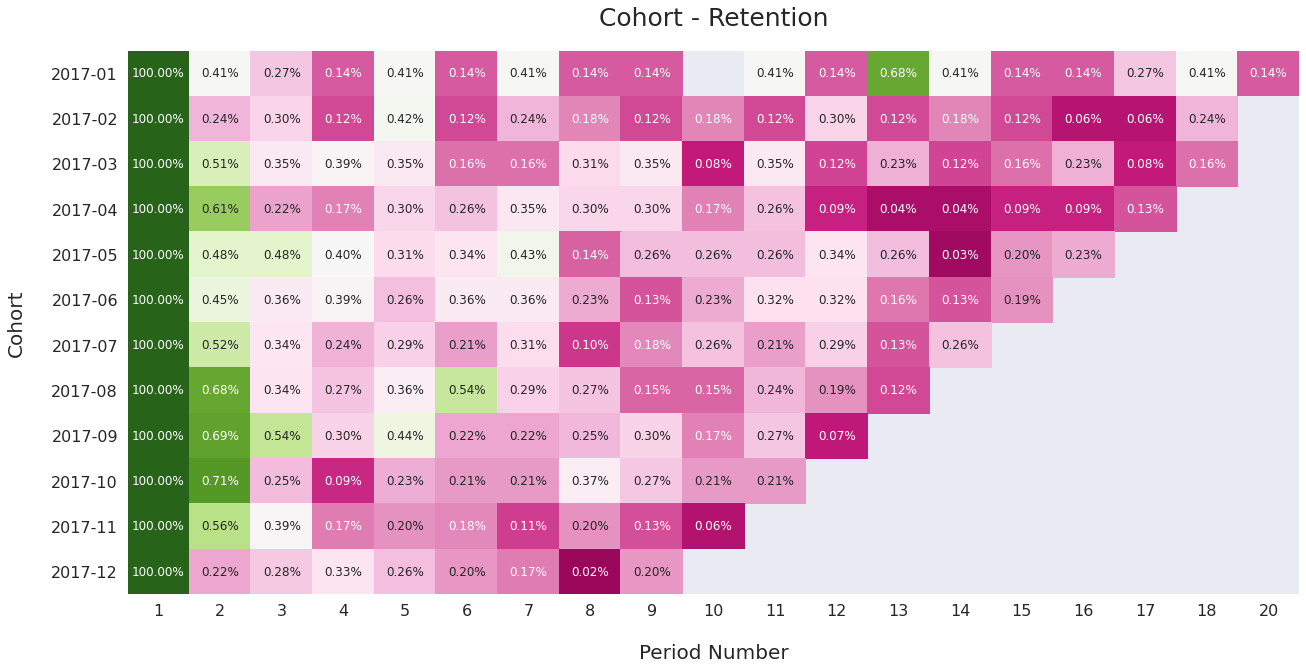

In [32]:
plt.figure(figsize=(21,10))
sns.heatmap(df_retention, 
            annot=True, 
            cmap='PiYG', 
            fmt='.2%', 
            vmin=0.0,
            vmax=0.008,
            cbar=False)
plt.yticks(rotation=0)
plt.title('Cohort - Retention', fontsize=25, pad=25) 
plt.xlabel('Period Number', fontsize=20, labelpad=25)
plt.ylabel('Cohort', fontsize=20, labelpad=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Самый высокий Retention на 3-й месяц был у когорты "2017-09"=0.54%

### 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации.  
Используя python, 
построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие 
метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за 
всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы 
метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, 
frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary 
от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. 

Считаем сколько раз клиент покупал (заказы, а не товары)

In [33]:
sold_merge=customers_orders_sold.merge(order_items, on='order_id')\
    .groupby(['order_id','order_purchase_timestamp','customer_unique_id'], as_index=False)\
    .agg({'price':'sum'})

Считаем NOW дату, добавив один день после последней покупки для подсчета Recency баллов

In [34]:
from datetime import timedelta
NOW = sold_merge['order_purchase_timestamp'].max() + timedelta(days=1)
NOW

Timestamp('2018-09-04 09:06:57')

Считаем количество дней во всем нашем периоде анализа

In [35]:
period = round((sold_merge['order_purchase_timestamp'].max()-sold_merge['order_purchase_timestamp'].min())/ np.timedelta64 ( 1 , 'D'),0)
period

728.0

Добавляю столбец с количеством дней между покупкой и NOW датой (минимум этого столбца для каждого клиента)

In [36]:
sold_merge['DaysSinceOrder'] = sold_merge['order_purchase_timestamp'].apply(lambda x: (NOW - x).days)
sold_merge.head()

,order_id,order_purchase_timestamp,customer_unique_id,price,DaysSinceOrder
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,58.90,356
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,239.90,495
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,199.00,232
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12.99,26
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,199.90,576


Посчитаем количество дней с момента покупки и количество покупок за весь период для каждого клиента

In [37]:
aggr = {
    'DaysSinceOrder': lambda x: x.min(),  # количество дней с дня покупки (Recency)
    'order_purchase_timestamp': lambda x: len([d for d in x if d >= NOW - timedelta(days=period)]), # общее количество заказов за период (Frequency)
}
rfm = sold_merge.groupby('customer_unique_id').agg(aggr).reset_index()
rfm.rename(columns={'DaysSinceOrder': 'Recency', 'order_purchase_timestamp': 'Frequency'}, inplace=True)
rfm.head()

,customer_unique_id,Recency,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1
2,0000f46a3911fa3c0805444483337064,542,1
3,0000f6ccb0745a6a4b88665a16c9f078,326,1
4,0004aac84e0df4da2b147fca70cf8255,293,1


Добавим столбец с продажами каждого клиента

In [38]:
rfm['Monetary'] = rfm['customer_unique_id'].apply(lambda x: sold_merge[(sold_merge['customer_unique_id'] == x) & \
                                                           (sold_merge['order_purchase_timestamp'] >= NOW - timedelta(days=period))]\
                                                           ['price'].sum())
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00


In [39]:
rfm.describe()

,Recency,Frequency,Monetary
count,94685.000000,94685.000000,94685.000000
mean,243.240756,1.033786,141.866102
std,152.828251,0.210737,215.713988
min,1.000000,0.000000,0.000000
25%,119.000000,1.000000,47.800000
50%,224.000000,1.000000,89.800000
75%,352.000000,1.000000,154.910000
max,729.000000,16.000000,13440.000000


#### Построим график для Recency

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


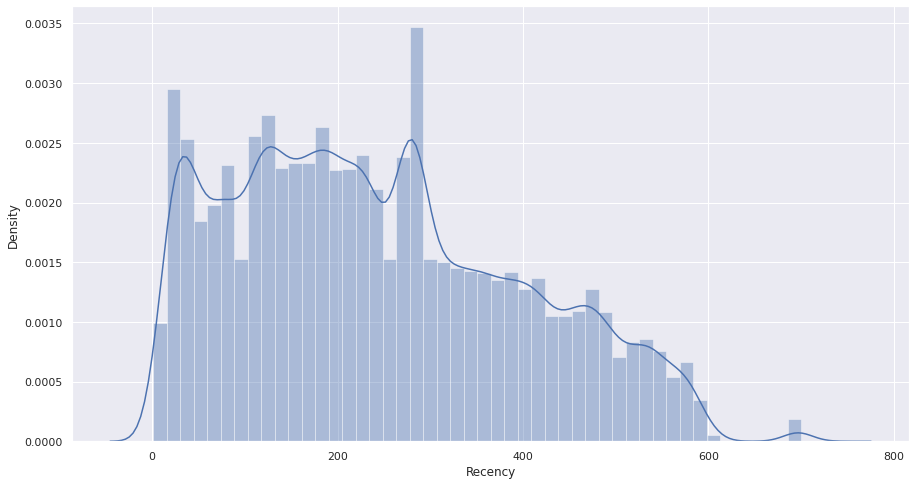

In [40]:
sns.distplot(rfm['Recency'])

Примерно после 300 дней идет спад количества пользователей.  
Определим границы Recency:  
Исходя из округленных данных процентилей 25, 50 и 75 %   
1-покупали давно-более 300 дней,  
2-покупали относительно недавно- от 120 до 300 дней,  
3-покупали недавно-от 1 до 120 дней

Функция для присвоения рангов от 1 до 3 для Recency

In [41]:
def r_score(x):
    if x>=300:
        return 1
    elif (x>120) and (x<300):
        return 2
    else:
        return 3

#### Построим график для Frequency

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Количество пользователей')

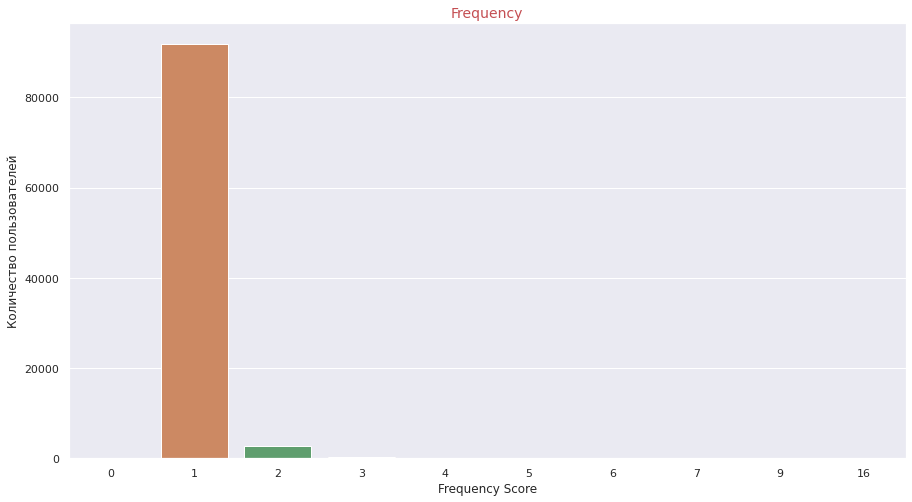

In [42]:
ax=sns.countplot(rfm['Frequency'])
ax.set_title('Frequency',fontsize=14, color='r')
ax.set_xlabel('Frequency Score')
ax.set_ylabel('Количество пользователей')

Видим, что почти все пользователи делали покупки редко или однократно.  
Для Frequency определим, что  
1-покупали редко или однократно-1,2 покупок,  
2-покупали несколько раз-3-5 покупок,  
3-покупали часто-более 5 раз

Функция для присвоения рангов от 1 до 3 для Frequency

In [43]:
def f_score(x):
    if x<=2:
        return 1
    elif (x>2) and (x<=5):
        return 2
    else:
        return 3

#### Построим график для Monetary

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


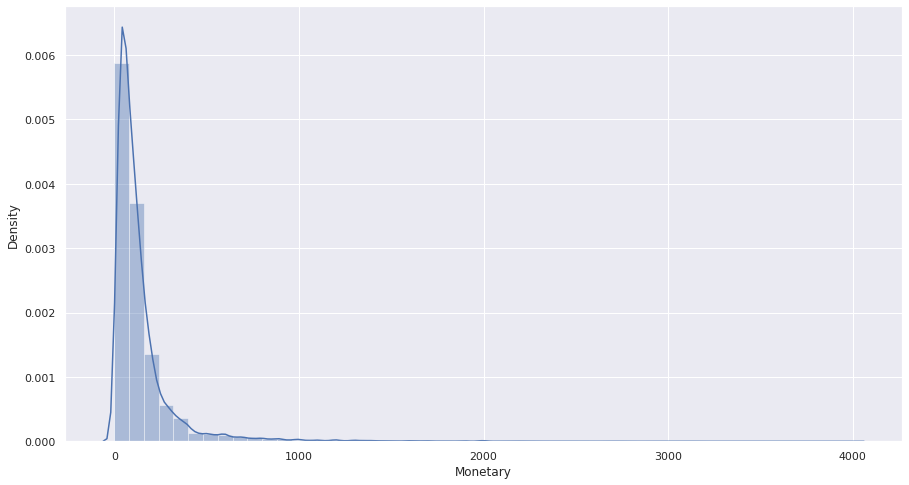

In [44]:
plt.ticklabel_format(style='plain')
sns.distplot(rfm[rfm['Monetary']<4000]['Monetary'])

Определим границы Monetary:   
Исходя из округленных данных процентилей 25, 50 и 75 %  
1 - маленькая сумма заказа- менее 50,  
2-средняя сумма заказа -от 50 до 200,  
3-большая сумма заказа- более 200

Функция для присвоения показателя Monetary

In [45]:
def m_score(x):
    if x<=50:
        return 1
    elif (x>50) and (x<=200):
        return 2
    else:
        return 3

Создаем столбцы с оценками по каждому параметру R, F и M для каждого клиента.

In [46]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['Monetary'].apply(lambda x: m_score(x))

Объединяем оценки R, F и M в столбец RFM Score.

In [47]:
rfm['RFMScore'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFMScore
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,3,1,2,312
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,2,212


Text(0, 0.5, 'RFMScore')

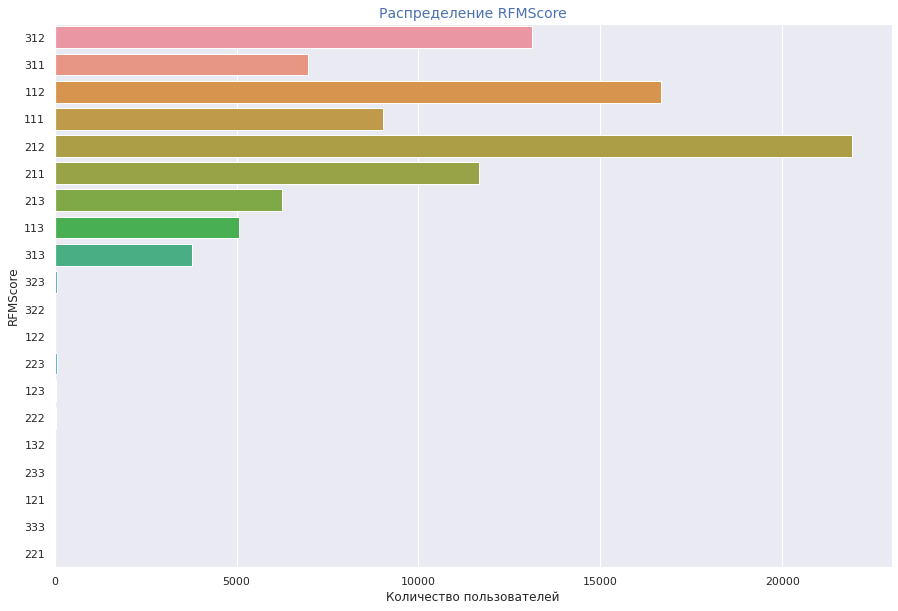

In [48]:
plt.figure(figsize=(15,10))
ax=sns.countplot(y=rfm['RFMScore'])
ax.set_title('Распределение RFMScore',fontsize=14, color='b')
ax.set_xlabel('Количество пользователей')
ax.set_ylabel('RFMScore')

Найдем в процентном соотношении каждую группу от общего кол-ва клиентов, совершивших покупки

In [49]:
percent = rfm.groupby('RFMScore').Recency.count().reset_index().rename(columns={'Recency': 'count_of_orders'})
percent['percent,%'] = round((percent['count_of_orders'] * 100) /percent['count_of_orders'].sum(),2)
percent

,RFMScore,count_of_orders,"percent,%"
0,111,9020,9.53
1,112,16682,17.62
2,113,5072,5.36
3,121,4,0.00
4,122,20,0.02
5,123,37,0.04
6,132,1,0.00
7,211,11664,12.32
8,212,21916,23.15
9,213,6253,6.60


R1—F1—M(1-3) — потерянные. Скорее всего, эти клиенты уже ушли от нас, и не стоит тратить слишком больших усилий на этот сегмент. Отправляем автоматическую цепочку реактивации.  
R1—F(2-3)—M(1-3) — лояльные клиенты, потерявшие активность.Эти клиенты сделали у нас несколько покупок, а потом перестали покупать. Отправляем им реактивационные письма, запрашиваем обратную связь, предлагаем бонусы, программы лояльности.  
R2-F(1-2)-M(1-3) — спящие.Эти клиенты ещё помнят о нас. Нужно попробовать расшевелить их стимулирующими акциями. Отправляем им рассылки с интересными акциями и выгодными предложениями.  
R2-F(3)-M(1-3) — лояльные спящие клиенты.Ещё не так давно они часто покупали у вас, а сейчас перестали. Также отправляем им рассылки с интересными акциями и выгодными предложениями.  
R3—F1—M(1-3) — новички.Отправляем welcome-цепочку с описанием преимуществ, ответами на частые вопросы, обучающие материалы.  
R3—F2—M(1-3) — развивающиеся. Нужно попытаться увеличить средний чек допродажей. Отправляем им рассылки с сопутствующими товарами.  
R3—F3—M(1-3) — постоянные.Отправляем им особые предложения, например, участие в программе лояльности — приглашение в клуб любимых клиентов.  
Пользователи «111» покупали давно, один раз и на маленькую сумму, они составляют 9.53% (не самая малочисленная группа относительно других). Постоянных клиентов очень мало.